In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib
import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기 및 전처리
ks200_data = pd.read_csv('../main/ks200.csv', encoding='utf-8')

# Label Encoding
encoder = LabelEncoder()
ks200_data['레이블'] = encoder.fit_transform(ks200_data['레이블'])

# 날짜 처리 및 정렬
ks200_data['날짜'] = pd.to_datetime(ks200_data['날짜'])
ks200_data.set_index('날짜', inplace=True)
ks200_data.sort_index(inplace=True)

# 특성과 레이블 분리
X = ks200_data.drop(columns=['레이블'])
y = ks200_data['레이블']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 초기화 및 하이퍼파라미터 그리드 정의
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=42)
param_dist_rf = {
    'n_estimators': [50, 100, 500],
    'max_leaf_nodes': [20, 30, 40, 50],
    'max_features': [1, 2, 3],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 하이퍼파라미터 튜닝
time_split_cv = TimeSeriesSplit(n_splits=10)
rnd_search = RandomizedSearchCV(rnd_clf, param_dist_rf, cv=time_split_cv, random_state=42)
rnd_search.fit(X_train, y_train)

# 최적 모델 선택 및 훈련
best_clf = rnd_search.best_estimator_
best_clf.fit(X_train, y_train)

# 모델 저장
joblib.dump(best_clf, "separation22.pkl")

# 예측 생성
y_pred_labels = best_clf.predict(X)

# 예측을 Series로 변환하여 인덱스 설정
y_pred_series = pd.Series(y_pred_labels, index=ks200_data.index, name='y_pred')

# real_data 로딩
real_data = pd.read_csv('back.csv')

# base_date를 날짜 형식으로 변환하고 인덱스로 설정
real_data['base_date'] = pd.to_datetime(real_data['base_date'], format='%Y-%m-%d')
real_data.set_index('base_date', inplace=True)

# ks200_data와 real_data의 공통 날짜 범위를 찾음
common_start = max(ks200_data.index.min(), real_data.index.min())
common_end = min(ks200_data.index.max(), real_data.index.max())

# 공통 날짜 범위로 데이터프레임을 자름
ks200_data_common = ks200_data.loc[common_start:common_end]
real_data_common = real_data.loc[common_start:common_end]

# y_pred_series(예측값)를 real_data_common에 병합
real_data_with_pred = pd.merge(real_data_common, y_pred_series, left_index=True, right_index=True, how='left')

# 데이터프레임의 처음 몇 행을 출력하여 확인
real_data_with_pred.head()


,before_last,KOSPI,m_return,y_pred
base_date,,,,
2011-04-29,2011-04-28,2192.360107,-0.007241,0
2011-05-31,2011-05-27,2142.469971,0.020107,0
2011-06-30,2011-06-29,2100.689941,0.002994,0
2011-07-29,2011-07-28,2133.209961,-0.010502,0
2011-08-31,2011-08-30,1880.109985,0.019682,0


In [2]:
# csv 파일로 저장
# real_data_with_pred.to_csv("33.csv")

In [3]:
# 데이터 다시 확인

import pandas as pd
import matplotlib.pyplot as plt

# Load the merged data
data = pd.read_csv('33.csv', parse_dates=['base_date', 'before_last'])
data.set_index('base_date', inplace=True)

# Ensure the data is sorted by date
data.sort_index(inplace=True)

# Display the first few rows of the data
data.head()

,before_last,KOSPI,m_return,y_pred
base_date,,,,
2011-04-29,2011-04-28,2192.360107,-0.007241,0
2011-05-31,2011-05-27,2142.469971,0.020107,0
2011-06-30,2011-06-29,2100.689941,0.002994,0
2011-07-29,2011-07-28,2133.209961,-0.010502,0
2011-08-31,2011-08-30,1880.109985,0.019682,0


In [4]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # 데이터 불러오기
# data = pd.read_csv('33.csv', index_col='base_date', parse_dates=True)

# # 예측값(y_pred)에 따라 전략 수익률(strategy_return) 계산
# data['strategy_return'] = np.where(data['y_pred'] == 2, data['m_return'],
#                                    np.where(data['y_pred'] == 0, -data['m_return'], 0))

# # 누적 수익률을 계산하여 포트폴리오 가치(portfolio_value)를 구함
# data['portfolio_value'] = (1 + data['strategy_return']).cumprod() * 100

# # 시장의 누적 수익률을 계산하여 시장 가치(market_value)를 구함
# data['market_value'] = (1 + data['m_return']).cumprod() * 100

# # 누적 수익률을 시각화
# plt.figure(figsize=(14, 7))
# plt.plot(data.index, data['portfolio_value'], label='Strategy', color='b')
# plt.plot(data.index, data['market_value'], label='Market', color='g')
# plt.title('Backtesting Result')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.grid(True)
# plt.show(), data.head()


         Metric  Portfolio    Market
0          CAGR  -0.003938  0.003784
1           MDD  -0.220285 -0.156375
2  Sharpe Ratio  -0.077170  0.104968


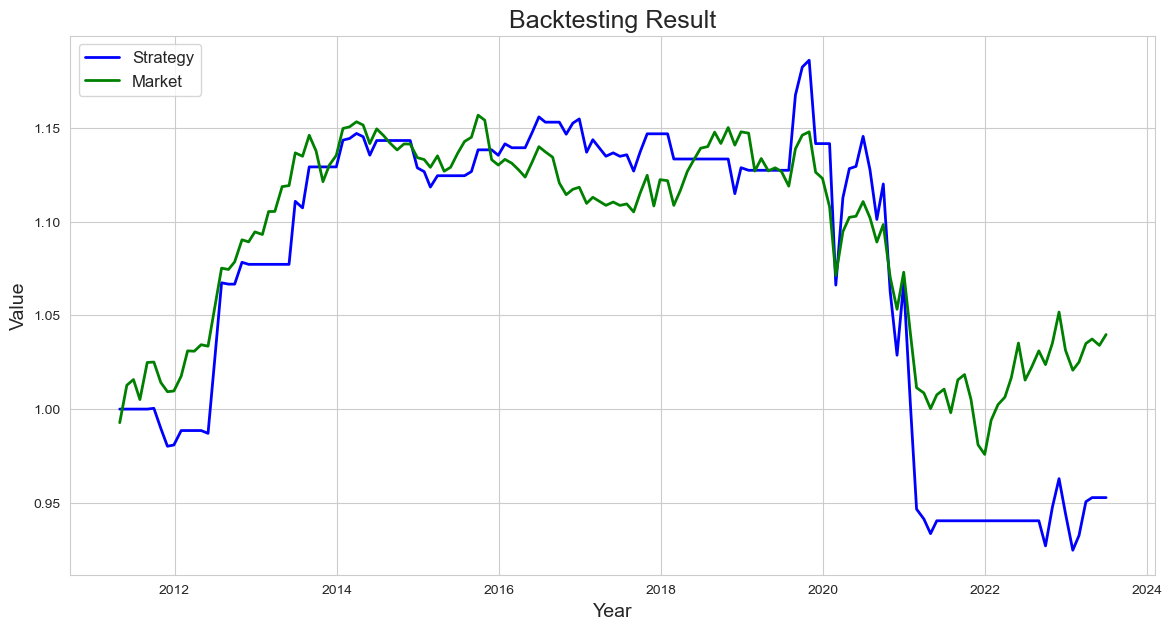

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
data = pd.read_csv('33.csv', index_col='base_date', parse_dates=True)

# 백테스팅 전략 수익률 계산
data['strategy_return'] = data['m_return'] * data['y_pred']
data['market_value'] = (data['m_return'] + 1).cumprod()
data['portfolio_value'] = (data['strategy_return'] + 1).cumprod()

# CAGR 계산
years = len(data) / 12  # 데이터는 월별로 주어져있음
final_portfolio_value = data['portfolio_value'].iloc[-1]
final_market_value = data['market_value'].iloc[-1]
CAGR_portfolio = (final_portfolio_value / data['portfolio_value'].iloc[0]) ** (1/years) - 1
CAGR_market = (final_market_value / data['market_value'].iloc[0]) ** (1/years) - 1

# MDD 계산
rolling_max_portfolio = data['portfolio_value'].cummax()
rolling_max_market = data['market_value'].cummax()
daily_drawdown_portfolio = data['portfolio_value']/rolling_max_portfolio - 1.0
daily_drawdown_market = data['market_value']/rolling_max_market - 1.0
MDD_portfolio = daily_drawdown_portfolio.min()
MDD_market = daily_drawdown_market.min()

# Sharpe Ratio 계산 (0% 무위험 수익률 가정)
std_dev_portfolio = data['strategy_return'].std() * np.sqrt(12)  # 월별 데이터이므로 연화하여 계산
std_dev_market = data['m_return'].std() * np.sqrt(12)
Sharpe_ratio_portfolio = (CAGR_portfolio) / std_dev_portfolio
Sharpe_ratio_market = (CAGR_market) / std_dev_market

# 결과를 DataFrame으로 저장
result = pd.DataFrame({
    'Metric': ['CAGR', 'MDD', 'Sharpe Ratio'],
    'Portfolio': [CAGR_portfolio, MDD_portfolio, Sharpe_ratio_portfolio],
    'Market': [CAGR_market, MDD_market, Sharpe_ratio_market]
})

# 결과 출력
print(result)

# 시각화 (시각적으로 더 전문적으로 만들기 위해 seaborn 스타일 사용)
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['portfolio_value'], label='Strategy', color='b', linewidth=2)
plt.plot(data.index, data['market_value'], label='Market', color='g', linewidth=2)
plt.title('Backtesting Result', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.show()



< AI 모델: 로드 완료 >

< 데이터 인덱스 확인 >
처음 5개의 인덱스: [Timestamp('2011-04-01 00:00:00'), Timestamp('2011-04-04 00:00:00'), Timestamp('2011-04-05 00:00:00'), Timestamp('2011-04-06 00:00:00'), Timestamp('2011-04-07 00:00:00')]
마지막 5개의 인덱스: [Timestamp('2023-06-26 00:00:00'), Timestamp('2023-06-27 00:00:00'), Timestamp('2023-06-28 00:00:00'), Timestamp('2023-06-29 00:00:00'), Timestamp('2023-06-30 00:00:00')]

< AI 모델: 학습 완료 >
전체 데이터의 정확도:  0.8720492644543277

<현재 상태>
WTI                  :   70.640
환율                   : 1323.070
VIX                  :   13.590
PER                  :   13.790
PBR                  :    0.920
통화량                  : 3795008.400
기준금리                 :    3.500
소비자물가지수              :  111.120
수입금액지수               :  147.330
수출금액지수               :  126.860
경제심리지수               :   92.900
경기종합지수               :   98.900
실업률                  :    2.600
고용률                  :   62.700
한국경제성장률              :    0.600
미국경제성장률              :    0.500

< AI 모델: 예측 >
예측:  ['do

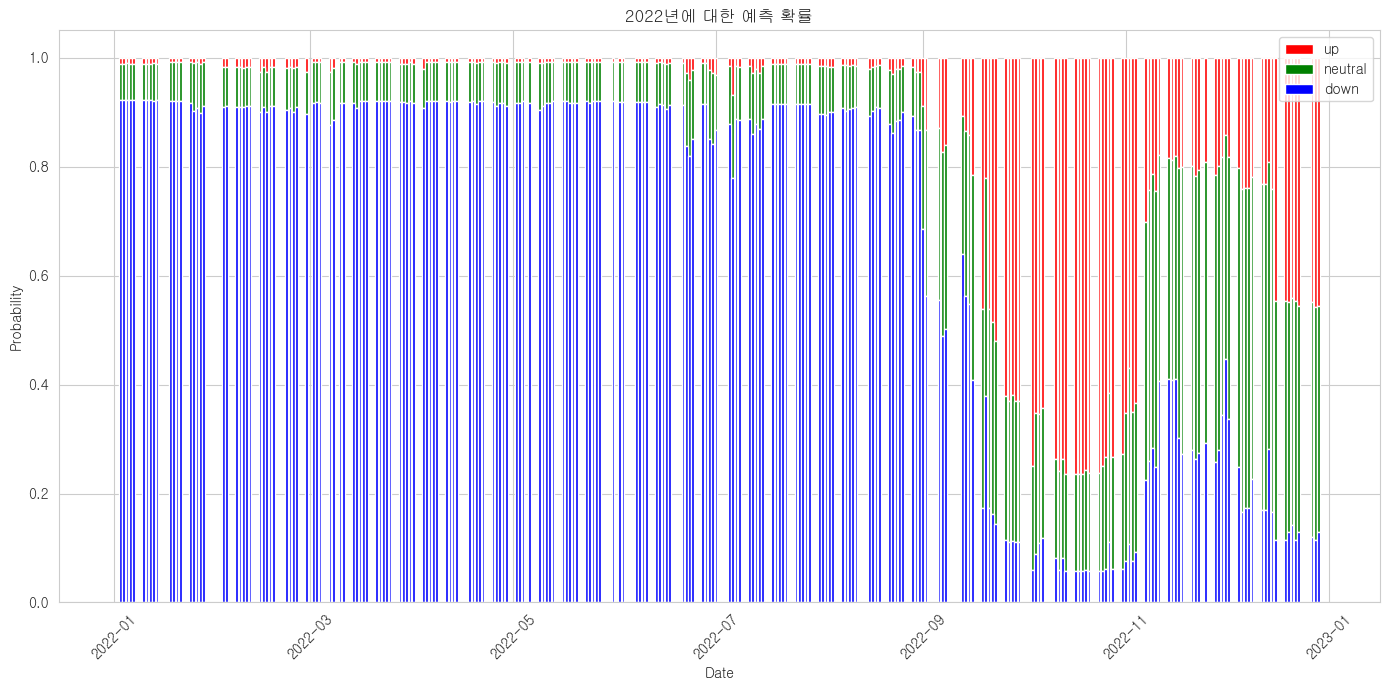

In [6]:
#6-30일 기준 60일 후 예측 시도

import warnings
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import joblib 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from matplotlib import font_manager, rc

# Korean font path
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)


# 경고 메시지 무시
warnings.filterwarnings("ignore")

# 모델 및 데이터 파일 경로 설정
MODEL_PATH = "separation22.pkl"  # 경로 수정
DATA_PATH = "../main/ks200.csv"  # 경로 수정

# 1. 모델 로드
rnd_clf = joblib.load(MODEL_PATH) 
print("\n< AI 모델: 로드 완료 >")

# 2. 데이터 로드 및 전처리
model_data = pd.read_csv(DATA_PATH, index_col='날짜', parse_dates=True)
X = model_data.iloc[:, 1:] 
y = model_data["레이블"] 

# 인덱스 확인
print("\n< 데이터 인덱스 확인 >")
print("처음 5개의 인덱스:", model_data.index[:5].tolist())
print("마지막 5개의 인덱스:", model_data.index[-5:].tolist())

# 레이블 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 3. 모델 학습
rnd_clf.fit(X, y_encoded)
print("\n< AI 모델: 학습 완료 >")
print("전체 데이터의 정확도: ", rnd_clf.score(X, y_encoded))

# 4. 현재 데이터의 상태 확인
print("\n<현재 상태>")
for col_name, score in zip(X.columns, X.iloc[-1]): 
    print(f"{col_name:20} : {score:8.3f}") 

# 현재 데이터를 예측에 사용하기 위해 형태를 변환합니다.
X_current = np.array(X.iloc[-1]).reshape(1,-1)

# 5. 현재 데이터로 예측
print("\n< AI 모델: 예측 >")
y_current_pred = rnd_clf.predict(X_current)
print("예측: ", label_encoder.inverse_transform(y_current_pred))

# 예측의 확률을 출력합니다.
prob_current = rnd_clf.predict_proba(X_current)
print("\n[클래스] : [확률]")
for name, prob in zip(label_encoder.classes_, prob_current[0]):
    print(f"{name:7} : {prob:.2f}")

# 6. 일별 전망치의 확률 변화 시각화
prob = rnd_clf.predict_proba(X)
prob_df = pd.DataFrame(prob, index=y.index, columns=label_encoder.classes_)
import matplotlib.pyplot as plt

# 원하는 레이블로 필터링하고 시각화합니다.
try:
    prob_2021 = prob_df.loc['2022']
except KeyError:
    print("2021 레이블로 데이터를 찾을 수 없습니다. 인덱스를 확인해주세요.")
else:
    plt.figure(figsize=(14, 7))
    plt.bar(prob_2021.index, prob_2021['up'], label='up', bottom=prob_2021['neutral']+prob_2021['down'], color='r')
    plt.bar(prob_2021.index, prob_2021['neutral'], label='neutral', bottom=prob_2021['down'], color='g')
    plt.bar(prob_2021.index, prob_2021['down'], label='down', color='b')
    plt.legend()
    plt.title("2022년에 대한 예측 확률")
    plt.xlabel('Date')
    plt.ylabel('Probability')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()